<a href="https://colab.research.google.com/github/shastraOfTrading/Demand-Supply-Identification/blob/main/Demand_Supply_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplfinance
!pip install mpl_finance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


Future Prediction

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

# Function to identify demand and supply zones with volume confirmation
def identify_zones(df, threshold=0.01):
    demand_zones = []
    supply_zones = []
    for i in range(1, len(df) - 1):
        volume_increase = df['Volume'].iloc[i] > df['Volume'].iloc[i - 1]
        # Demand Zone
        if (df['Low'].iloc[i] < df['Low'].iloc[i - 1] and df['Low'].iloc[i] < df['Low'].iloc[i + 1]):
            demand_price = df['Low'].iloc[i]
            if volume_increase and df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
                if not any(np.isclose(demand_price, zone, atol=demand_price * threshold) for zone in demand_zones):
                    demand_zones.append(demand_price)

        # Supply Zone
        if (df['High'].iloc[i] > df['High'].iloc[i - 1] and df['High'].iloc[i] > df['High'].iloc[i + 1]):
            supply_price = df['High'].iloc[i]
            if volume_increase and df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
                if not any(np.isclose(supply_price, zone, atol=supply_price * threshold) for zone in supply_zones):
                    supply_zones.append(supply_price)

    current_price = df['Close'].iloc[-1] if not df.empty else None
    nearest_demand_zone = min(demand_zones, key=lambda x: abs(x - current_price), default=None) if demand_zones else None
    nearest_supply_zone = min(supply_zones, key=lambda x: abs(x - current_price), default=None) if supply_zones else None

    return nearest_demand_zone, nearest_supply_zone

# Function to add technical indicators to the dataframe
def add_technical_indicators(df):
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['Momentum'] = df['Close'].diff(4)  # 4-day momentum
    df.dropna(inplace=True)

# Function to predict the next day's closing price using regression models
def predict_next_move(df, model_type='linear'):
    if df.empty or len(df) < 2:
        return None, "Insufficient Data"

    add_technical_indicators(df)
    X = df[['MA_5', 'MA_20', 'Momentum']]
    y = df['Close']

    if len(X) < 2:
        return None, "Insufficient Data"

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression() if model_type == 'linear' else RandomForestRegressor()
    model.fit(X_train, y_train)

    next_day_features = pd.DataFrame([[df['MA_5'].iloc[-1], df['MA_20'].iloc[-1], df['Momentum'].iloc[-1]]],
                                      columns=['MA_5', 'MA_20', 'Momentum'])
    predicted_next_close = model.predict(next_day_features)[0]

    # Trend analysis signal
    trend_signal = None
    if df['MA_5'].iloc[-1] > df['MA_20'].iloc[-1]:
        trend_signal = "Buy"
    elif df['MA_5'].iloc[-1] < df['MA_20'].iloc[-1]:
        trend_signal = "Sell"
    else:
        trend_signal = "Sideways"

    return predicted_next_close, trend_signal

# Function to determine optimal buy/sell times based on historical data
def get_optimal_trade_times(df):
    df['Hour'] = df.index.hour
    buy_times = df[df['Close'].diff() > 0].groupby('Hour').count()['Close']
    sell_times = df[df['Close'].diff() < 0].groupby('Hour').count()['Close']

    optimal_buy_time = buy_times.idxmax()
    optimal_sell_time = sell_times.idxmax()

    return optimal_buy_time, optimal_sell_time

# Function to generate trade summary table
def generate_trade_summary(df, ticker, nearest_demand_zone, nearest_supply_zone, predicted_next_close, trend_signal):
    current_price = df['Close'].iloc[-1] if not df.empty else None
    target = predicted_next_close * 1.01  # Target at 1% above predicted close
    stop_loss = predicted_next_close * 0.99  # Stop loss at 1% below predicted close

    # Calculate prediction accuracy
    if current_price is not None:
        accuracy_percentage = ((predicted_next_close - current_price) / current_price) * 100
    else:
        accuracy_percentage = None

    data = {
        "Symbol": [ticker],
        "LTP": [current_price],
        "Predicted Next Close": [predicted_next_close],
        "Trend Signal": [trend_signal],
        "Buy at Demand Zone": [nearest_demand_zone],
        "Sell at Supply Zone": [nearest_supply_zone],
        "Target Price": [target],
        "Stop Loss Price": [stop_loss],
        "Prediction Accuracy (%)": [accuracy_percentage],
    }

    summary_df = pd.DataFrame(data)
    return summary_df

# Function to update the chart
def update_chart(ticker, interval):
    clear_output(wait=True)

    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)  # Fetch last 30 days of data
    df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval=interval)

    if df.empty:
        print("No data fetched for the selected ticker and interval.")
        return

    nearest_demand_zone, nearest_supply_zone = identify_zones(df)
    predicted_next_close, trend_signal = predict_next_move(df, model_type='random_forest')

    # Get optimal trade times
    optimal_buy_time, optimal_sell_time = get_optimal_trade_times(df)

    # Generate summary table
    trade_summary = generate_trade_summary(df, ticker, nearest_demand_zone, nearest_supply_zone, predicted_next_close, trend_signal)

    # Display summary table
    trade_summary["Optimal Buy Time"] = optimal_buy_time
    trade_summary["Optimal Sell Time"] = optimal_sell_time
    display(trade_summary)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    mpf.plot(df, type='candle', ax=ax, volume=False, warn_too_much_data=1000)

    if nearest_demand_zone is not None:
        ax.axhline(y=nearest_demand_zone, color='lightgreen', linestyle='--', label='Nearest Demand Zone')

    if nearest_supply_zone is not None:
        ax.axhline(y=nearest_supply_zone, color='red', linestyle='--', label='Nearest Supply Zone')

    ax.set_title(f"{ticker} Nearest Supply and Demand Zones")
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show()

# Dropdowns for ticker and interval
ticker_dropdown = widgets.Dropdown(
    options=["TRENT.NS", "DMART.NS", "INFY.NS", "TCS.NS", "RELIANCE.NS", "ONGC.NS"],
    value='TRENT.NS',
    description='Ticker:'
)

interval_dropdown = widgets.Dropdown(
    options=['1m', '5m', '15m', '1h', '1d'],
    value='5m',
    description='Interval:'
)

# Create an interactive output
ui = widgets.HBox([ticker_dropdown, interval_dropdown])
out = widgets.interactive_output(update_chart, {'ticker': ticker_dropdown, 'interval': interval_dropdown})
display(ui, out)


Output()

In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

# Function to identify demand and supply zones with volume confirmation
def identify_zones(df, threshold=0.01):
    demand_zones = []
    supply_zones = []

    for i in range(1, len(df) - 1):
        volume_increase = df['Volume'].iloc[i] > df['Volume'].iloc[i - 1]

        # Identify demand zone
        if (df['Low'].iloc[i] < df['Low'].iloc[i - 1] and
            df['Low'].iloc[i] < df['Low'].iloc[i + 1]):
            demand_price = df['Low'].iloc[i]
            if volume_increase and df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
                demand_zones.append({'price': demand_price, 'violated': False})

        # Identify supply zone
        if (df['High'].iloc[i] > df['High'].iloc[i - 1] and
            df['High'].iloc[i] > df['High'].iloc[i + 1]):
            supply_price = df['High'].iloc[i]
            if volume_increase and df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
                supply_zones.append({'price': supply_price, 'violated': False})

    # Get the current price
    current_price = df['Close'].iloc[-1]

    # Check if any zones have been violated
    for zone in demand_zones:
        if current_price < zone['price']:  # Price has crossed below a demand zone
            zone['violated'] = True

    for zone in supply_zones:
        if current_price > zone['price']:  # Price has crossed above a supply zone
            zone['violated'] = True

    # Filter out violated zones
    valid_demand_zones = [zone for zone in demand_zones if not zone['violated']]
    valid_supply_zones = [zone for zone in supply_zones if not zone['violated']]

    # Find the nearest valid demand and supply zones
    nearest_demand_zone = min(valid_demand_zones, key=lambda x: abs(x['price'] - current_price), default=None)
    nearest_supply_zone = min(valid_supply_zones, key=lambda x: abs(x['price'] - current_price), default=None)

    return nearest_demand_zone, nearest_supply_zone

# Function to update the chart
def update_chart(ticker, interval):
    clear_output(wait=True)

    # Calculate dynamic dates
    end_date = datetime.now()
    start_date = end_date - timedelta(days=7)  # Last 7 days of data
    print("Start Date:", start_date.strftime('%Y-%m-%d'), "End Date:", end_date.strftime('%Y-%m-%d'))
    # Download historical data
    df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval=interval)
    print(df)
    # Identify zones
    nearest_demand_zone, nearest_supply_zone = identify_zones(df)

    # Print identified zones
    if nearest_demand_zone is not None:
        print(f"Nearest Demand Zone: {nearest_demand_zone['price']} (Fresh Zone)")

    if nearest_supply_zone is not None:
        print(f"Nearest Supply Zone: {nearest_supply_zone['price']} (Fresh Zone)")

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    mpf.plot(df, type='candle', ax=ax, volume=False)

    # Add nearest demand zone (light green)
    if nearest_demand_zone is not None:
        ax.axhline(y=nearest_demand_zone['price'], color='lightgreen', linestyle='--', label='Nearest Demand Zone')

    # Add nearest supply zone (red)
    if nearest_supply_zone is not None:
        ax.axhline(y=nearest_supply_zone['price'], color='red', linestyle='--', label='Nearest Supply Zone')

    ax.set_title(f"{ticker} Nearest Supply and Demand Zones with Volume Confirmation")
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    strategy_text = ("Strategy: Nearest Supply and Demand Zone Identification\n"
                     "Only fresh zones are shown. Violated zones are not displayed.")
    plt.text(0.5, 0.95, strategy_text, horizontalalignment='center', verticalalignment='center',
             transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    ax.legend()
    plt.show()

# Dropdowns for ticker and interval
ticker_dropdown = widgets.Dropdown(
    options=["TRENT.NS", "DMART.NS", "INFY.NS", "TCS.NS", "RELIANCE.NS", "ONGC.NS",
             "HDFCBANK.NS", "ICICIBANK.NS", "HINDUNILVR.NS", "ITC.NS", "TATAMOTORS.NS",
             "BAJAJ-AUTO.NS", "SUNPHARMA.NS", "DRREDDY.NS", "ULTRACEMCO.NS", "ACC.NS",
             "ASIANPAINT.NS", "DIXON.NS", "NTPC.NS", "TATAPOWER.NS"],
    value='INFY.NS',
    description='Ticker:'
)

interval_dropdown = widgets.Dropdown(
    options=['1m', '5m', '15m', '30m', '1h', '1d'],
    value='15m',
    description='Interval:'
)

# Create an interactive output
widgets.interactive(update_chart, ticker=ticker_dropdown, interval=interval_dropdown)


interactive(children=(Dropdown(description='Ticker:', index=2, options=('TRENT.NS', 'DMART.NS', 'INFY.NS', 'TC…

In [ ]:
df.head()

NameError: name 'df' is not defined

In [ ]:
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Adj Close']]

In [ ]:
def isSupport(df, i):
    # Support if the current low is lower than previous and next lows
    return (df['Low'].iloc[i] < df['Low'].iloc[i - 1] and
            df['Low'].iloc[i] < df['Low'].iloc[i + 1])

def isResistance(df, i):
    # Resistance if the current high is higher than previous and next highs
    return (df['High'].iloc[i] > df['High'].iloc[i - 1] and
            df['High'].iloc[i] > df['High'].iloc[i + 1])

# Lists to hold support and resistance levels
support_levels = []
resistance_levels = []

# Loop through the DataFrame to find support and resistance levels
for i in range(2, df.shape[0] - 2):
    if isSupport(df, i):
        support_levels.append((df.index[i], df['Low'].iloc[i]))

    if isResistance(df, i):
        resistance_levels.append((df.index[i], df['High'].iloc[i]))

# Print the levels found
print("Support Levels:")
for level in support_levels:
    print(f"Date: {level[0]}, Support Level: {level[1]}")

print("\nResistance Levels:")
for level in resistance_levels:
    print(f"Date: {level[0]}, Resistance Level: {level[1]}")

Support Levels:

Resistance Levels:
Date: 2024-10-09 00:00:00, Resistance Level: 8322.2001953125


In [ ]:
levels = []
for i in range(2, df.shape[0] - 2):
    # Check for support
    support = (df['Low'].iloc[i] < df['Low'].iloc[i - 1] and
               df['Low'].iloc[i] < df['Low'].iloc[i + 1])

    # Check for resistance
    resistance = (df['High'].iloc[i] > df['High'].iloc[i - 1] and
                  df['High'].iloc[i] > df['High'].iloc[i + 1] and
                  df['High'].iloc[i + 1] > df['High'].iloc[i + 2] and
                  df['High'].iloc[i - 1] > df['High'].iloc[i - 2])

    if support:
        levels.append((i, df['Low'].iloc[i]))
    elif resistance:
        levels.append((i, df['High'].iloc[i]))

# Now you can use the levels list as needed
print(levels)


[]


In [ ]:
def plot_all():
  fig, ax = plt.subplots()

  candlestick_ohlc(ax,df.values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)

  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()

  fig.tight_layout()

  for level in levels:
    plt.hlines(level[1],xmin=df['Date'][level[0]],\
               xmax=max(df['Date']),colors='blue')
  fig.show()

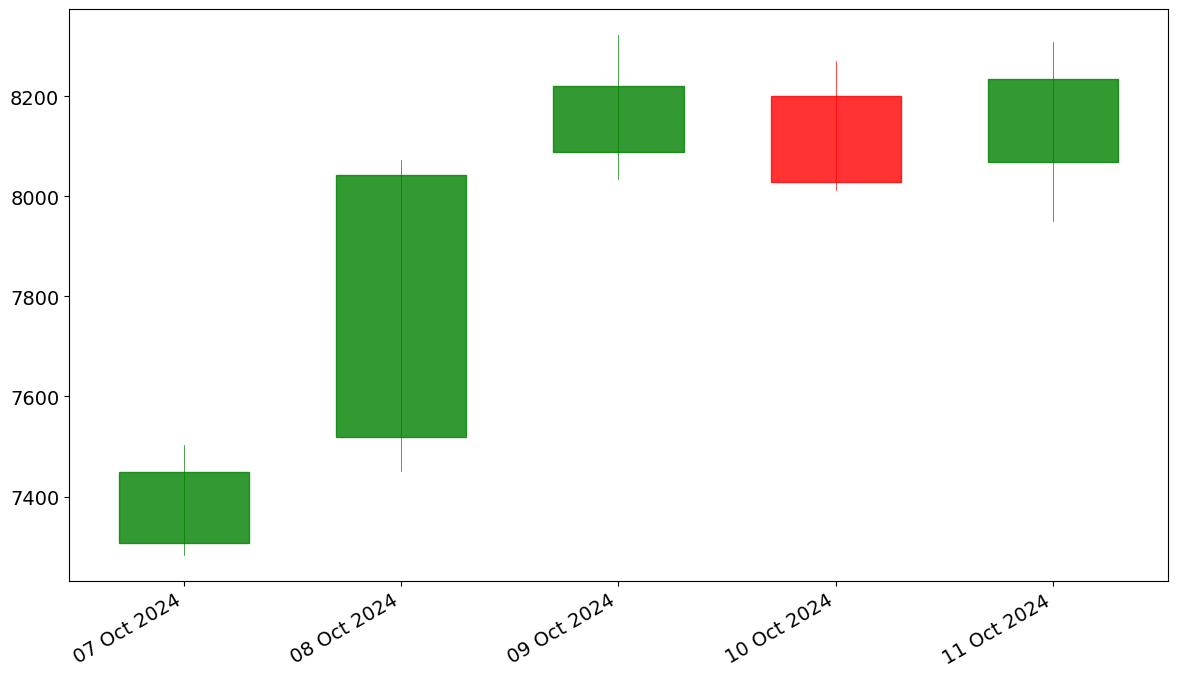

In [ ]:
plot_all()


In [ ]:
s =  np.mean(df['High'] - df['Low'])


In [ ]:
def isFarFromLevel(l):
  return np.sum([abs(l-x) < s  for x in levels]) == 0

In [ ]:
levels = []
for i in range(2, df.shape[0] - 2):
    # Check for support
    support = (df['Low'].iloc[i] < df['Low'].iloc[i - 1] and
               df['Low'].iloc[i] < df['Low'].iloc[i + 1])

    # Check for resistance
    resistance = (df['High'].iloc[i] > df['High'].iloc[i - 1] and
                  df['High'].iloc[i] > df['High'].iloc[i + 1] and
                  df['High'].iloc[i + 1] > df['High'].iloc[i + 2] and
                  df['High'].iloc[i - 1] > df['High'].iloc[i - 2])

    if support:
        l = df['Low'].iloc[i]  # Use .iloc for positional indexing
        if isFarFromLevel(l):
            levels.append((i, l))

    elif resistance:
        l = df['High'].iloc[i]  # Use .iloc for positional indexing
        if isFarFromLevel(l):
            levels.append((i, l))

# Now you can use the levels list as needed
print(levels)


[]


In [ ]:
levels

[]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


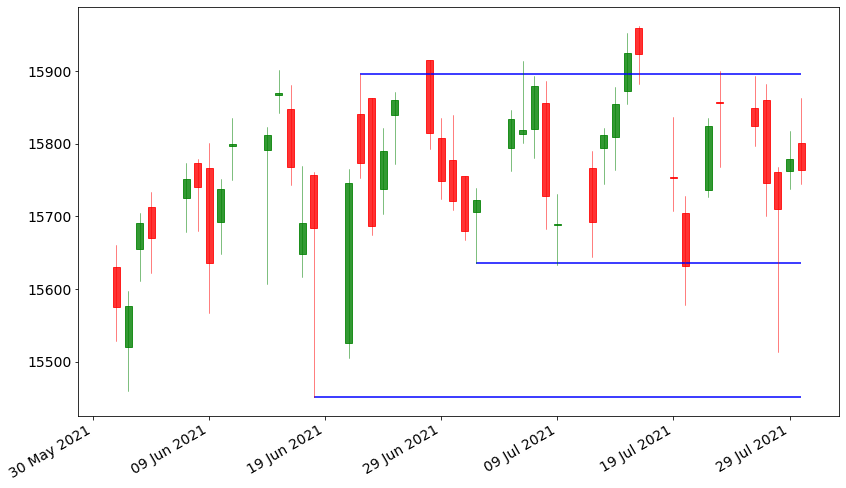

In [ ]:
plot_all()
